In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.stats
import tarfile as tar
import requests
import json
import re
import glob #for file import

In [2]:
# In order to get the full information, let's display always the entire df
pd.set_option('display.max_rows', None, 'display.max_columns', None)

# Part I: Data acquisition, formatting and clean-up

## Available data of the TCGA

The TCGA represents the most important medical database on cancer worldwide. It includes extensive clinical and sequencing data about patients suffering from cancers. All cancer entities have been included.

We will be working with patients suffering from primary non-small cell lung cancer. Furthermore, we will focus only on patients suffering from __lung adenocarcinoma__ or __lung squamous cell carcinoma__ which represent the most prevalent histological entities.

TCGA data can be accessed via the _GDC (Genomic Data Commons) Data portal_. This portal includes mainly sequencing information but also clinical information and for some cases scanned histological images. _Python_ can be used to retrieve easily data from the GDC API in order to use it for downstream analyses.

In [ ]:
# Script from official GDC TCGA site -> best way to query files via python based on a filtered search

files_endpt = "https://api.gdc.cancer.gov/files"

'''Filters adapted to the receive the exact files for further analyses -> clinical data on lung cancer cases. Only
adeno- and squamous cell carcinomas, tab separated txt-files from patients with known status (dead or alive).
''' 

filters = {
    "op": "and",
    "content":[
        {
        "op": "in",
        "content":{
            "field": "cases.demographic.vital_status",
            "value": ["alive", "dead"]
            }
        },
        {
        "op": "in",
        "content":{
            "field": "cases.disease_type",
            "value": ["adenomas and adenocarcinomas", "squamous cell neoplasms"]
            }
        },
        {
        "op": "in",
        "content":{
            "field": "cases.primary_site",
            "value": ["bronchus and lung"]
            }
        },
        {
        "op": "in",
        "content":{
            "field": "files.data_category",
            "value": ["clinical"]
            }
        },
        {
        "op": "in",
        "content":{
            "field": "files.data_format",
            "value": ["bcr biotab"]
            }
        }
    ]
}

# Here a GET is used, so the filter parameters should be passed as a JSON string.

params = {
    "filters": json.dumps(filters),
    "fields": "file_id",
    "format": "JSON",
    "size": "1000"
    }

response = requests.get(files_endpt, params = params)

file_uuid_list = []

# This step populates the download list with the file_ids from the previous query
for file_entry in json.loads(response.content.decode("utf-8"))["data"]["hits"]:
    file_uuid_list.append(file_entry["file_id"])

data_endpt = "https://api.gdc.cancer.gov/data"

params = {"ids": file_uuid_list}

response = requests.post(data_endpt, data = json.dumps(params), headers = {"Content-Type": "application/json"})

response_head_cd = response.headers["Content-Disposition"]

file_name = re.findall("filename=(.+)", response_head_cd)[0]

with open(file_name, "wb") as output_file:
    output_file.write(response.content)

In [ ]:
for f in glob.glob('./gdc_download_*.tar.gz'):
    tar = tar.open(f)
    tar.extractall(path = './TCGA')
    tar.close()

In [3]:
all_dfs = []
for i, filename in enumerate(glob.glob('./TCGA/*/*.txt')):
   with open(os.path.join(os.getcwd(), filename), 'r') as f:
    all_dfs.append(pd.read_csv(filepath_or_buffer = filename, sep = "\t"))

In [4]:
for df in all_dfs:
    df.drop([0,1], axis = 0, inplace = True)

In [5]:
all_TCGA_df = all_dfs.pop(0)
all_TCGA_df = all_TCGA_df.append(all_dfs)

In [6]:
TCGA_interesting =all_TCGA_df[["bcr_patient_uuid", "histologic_diagnosis", "history_neoadjuvant_treatment", "last_contact_days_to","ajcc_pathologic_tumor_stage", "death_days_to", "vital_status", "age_at_initial_pathologic_diagnosis"]]
TCGA_interesting.head(100)

,bcr_patient_uuid,histologic_diagnosis,history_neoadjuvant_treatment,last_contact_days_to,ajcc_pathologic_tumor_stage,death_days_to,vital_status,age_at_initial_pathologic_diagnosis
2,95b83006-02c9-4c4d-bf84-a45115f7d86d,Lung Squamous Cell Carcinoma,No,[Not Available],Stage IA,371,Dead,67
3,4e1ad82e-23c8-44bb-b74e-a3d0b1126b96,Lung Squamous Cell Carcinoma,No,[Not Available],Stage IB,136,Dead,72
4,d4bc755a-2585-4529-ae36-7e1d88bdecfe,Lung Squamous Cell Carcinoma,No,2099,Stage IB,[Not Applicable],Alive,77
5,b09e872a-e837-49ec-8a27-84dcdcabf347,Lung Squamous Cell Carcinoma,No,2417,Stage IA,[Not Applicable],Alive,74
6,99599b60-4f5c-456b-8755-371b1aa7074e,Lung Squamous Cell Carcinoma,No,[Not Available],Stage IIB,146,Dead,81
7,f1a1bbf9-4751-4fb4-8a2b-19f8d4ba57bd,Lung Squamous Cell Carcinoma,No,1415,Stage IIIA,[Not Applicable],Alive,63
8,c8802713-b814-4b55-993f-3ffebf8c3ab8,Lung Squamous Cell Carcinoma,No,[Not Available],Stage IB,345,Dead,52
9,af1d9d69-0a45-4ad3-9873-57fbe4a4b895,Lung Squamous Cell Carcinoma,No,[Not Available],Stage IV,716,Dead,73
10,9a874b64-d0d6-416e-97bc-e9071ed0b16b,Lung Squamous Cell Carcinoma,No,1810,Stage IB,[Not Applicable],Alive,77
11,6eb61cab-8e83-4c18-a59a-ae0985ec9d2e,Lung Squamous Cell Carcinoma,No,956,Stage IIB,[Not Applicable],Alive,83


In [7]:
TCGA_interesting['last_contact_days_to'] = TCGA_interesting.apply(
    lambda row: row['death_days_to'] if row['last_contact_days_to'] == '[Not Available]' else row['last_contact_days_to'],
    axis=1
)

len(TCGA_interesting.index)

<ipython-input-7-4be3d90934fc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TCGA_interesting['last_contact_days_to'] = TCGA_interesting.apply(


3485

In [8]:
TCGA_interesting = TCGA_interesting.dropna(subset = ['vital_status'])
TCGA_interesting = TCGA_interesting.dropna(subset = ['ajcc_pathologic_tumor_stage'])
TCGA_interesting = TCGA_interesting.dropna(subset = ['last_contact_days_to'])
print(len(TCGA_interesting.index))
TCGA_interesting

1026


,bcr_patient_uuid,histologic_diagnosis,history_neoadjuvant_treatment,last_contact_days_to,ajcc_pathologic_tumor_stage,death_days_to,vital_status,age_at_initial_pathologic_diagnosis
2,95b83006-02c9-4c4d-bf84-a45115f7d86d,Lung Squamous Cell Carcinoma,No,371,Stage IA,371,Dead,67
3,4e1ad82e-23c8-44bb-b74e-a3d0b1126b96,Lung Squamous Cell Carcinoma,No,136,Stage IB,136,Dead,72
4,d4bc755a-2585-4529-ae36-7e1d88bdecfe,Lung Squamous Cell Carcinoma,No,2099,Stage IB,[Not Applicable],Alive,77
5,b09e872a-e837-49ec-8a27-84dcdcabf347,Lung Squamous Cell Carcinoma,No,2417,Stage IA,[Not Applicable],Alive,74
6,99599b60-4f5c-456b-8755-371b1aa7074e,Lung Squamous Cell Carcinoma,No,146,Stage IIB,146,Dead,81
7,f1a1bbf9-4751-4fb4-8a2b-19f8d4ba57bd,Lung Squamous Cell Carcinoma,No,1415,Stage IIIA,[Not Applicable],Alive,63
8,c8802713-b814-4b55-993f-3ffebf8c3ab8,Lung Squamous Cell Carcinoma,No,345,Stage IB,345,Dead,52
9,af1d9d69-0a45-4ad3-9873-57fbe4a4b895,Lung Squamous Cell Carcinoma,No,716,Stage IV,716,Dead,73
10,9a874b64-d0d6-416e-97bc-e9071ed0b16b,Lung Squamous Cell Carcinoma,No,1810,Stage IB,[Not Applicable],Alive,77
11,6eb61cab-8e83-4c18-a59a-ae0985ec9d2e,Lung Squamous Cell Carcinoma,No,956,Stage IIB,[Not Applicable],Alive,83


In [9]:
TCGA_interesting = TCGA_interesting[TCGA_interesting['last_contact_days_to'] != '[Discrepancy]']
TCGA_interesting = TCGA_interesting[TCGA_interesting['last_contact_days_to'] != '[Not Available]']
TCGA_interesting = TCGA_interesting[TCGA_interesting['last_contact_days_to'] != '[Not Applicable]']
TCGA_interesting = TCGA_interesting[TCGA_interesting['ajcc_pathologic_tumor_stage'] != '[Discrepancy]']
print(len(TCGA_interesting.index))
TCGA_interesting

984


,bcr_patient_uuid,histologic_diagnosis,history_neoadjuvant_treatment,last_contact_days_to,ajcc_pathologic_tumor_stage,death_days_to,vital_status,age_at_initial_pathologic_diagnosis
2,95b83006-02c9-4c4d-bf84-a45115f7d86d,Lung Squamous Cell Carcinoma,No,371,Stage IA,371,Dead,67
3,4e1ad82e-23c8-44bb-b74e-a3d0b1126b96,Lung Squamous Cell Carcinoma,No,136,Stage IB,136,Dead,72
4,d4bc755a-2585-4529-ae36-7e1d88bdecfe,Lung Squamous Cell Carcinoma,No,2099,Stage IB,[Not Applicable],Alive,77
5,b09e872a-e837-49ec-8a27-84dcdcabf347,Lung Squamous Cell Carcinoma,No,2417,Stage IA,[Not Applicable],Alive,74
6,99599b60-4f5c-456b-8755-371b1aa7074e,Lung Squamous Cell Carcinoma,No,146,Stage IIB,146,Dead,81
7,f1a1bbf9-4751-4fb4-8a2b-19f8d4ba57bd,Lung Squamous Cell Carcinoma,No,1415,Stage IIIA,[Not Applicable],Alive,63
8,c8802713-b814-4b55-993f-3ffebf8c3ab8,Lung Squamous Cell Carcinoma,No,345,Stage IB,345,Dead,52
9,af1d9d69-0a45-4ad3-9873-57fbe4a4b895,Lung Squamous Cell Carcinoma,No,716,Stage IV,716,Dead,73
10,9a874b64-d0d6-416e-97bc-e9071ed0b16b,Lung Squamous Cell Carcinoma,No,1810,Stage IB,[Not Applicable],Alive,77
11,6eb61cab-8e83-4c18-a59a-ae0985ec9d2e,Lung Squamous Cell Carcinoma,No,956,Stage IIB,[Not Applicable],Alive,83


In [10]:
conditions_TCGAsurv = [
    (TCGA_interesting['vital_status'] == 'Dead'),
    (TCGA_interesting['vital_status'] == 'Alive')
]
values_TCGAsurv = [1, 0]
TCGA_interesting['STATOS'] = np.select(conditions_TCGAsurv, values_TCGAsurv)

conditions_TCGAstage = [
    (TCGA_interesting['ajcc_pathologic_tumor_stage'] == 'Stage I'),
    (TCGA_interesting['ajcc_pathologic_tumor_stage'] == 'Stage IA'),
    (TCGA_interesting['ajcc_pathologic_tumor_stage'] == 'Stage IB'),
    (TCGA_interesting['ajcc_pathologic_tumor_stage'] == 'Stage II'),
    (TCGA_interesting['ajcc_pathologic_tumor_stage'] == 'Stage IIA'),
    (TCGA_interesting['ajcc_pathologic_tumor_stage'] == 'Stage IIB'),
    (TCGA_interesting['ajcc_pathologic_tumor_stage'] == 'Stage III'),
    (TCGA_interesting['ajcc_pathologic_tumor_stage'] == 'Stage IIIA'),
    (TCGA_interesting['ajcc_pathologic_tumor_stage'] == 'Stage IIIB'),
    (TCGA_interesting['ajcc_pathologic_tumor_stage'] == 'Stage IV')
]
values_TCGAstage = [10, 11, 12, 20, 21, 22, 30, 31, 32, 40]
TCGA_interesting['stage_short'] = np.select(conditions_TCGAstage, values_TCGAstage)

conditions_TCGAstage = [
    (TCGA_interesting['stage_short'] < 20),
    (TCGA_interesting['stage_short'] < 30),
    (TCGA_interesting['stage_short'] < 40),
    (TCGA_interesting['stage_short'] == 40)
]
values_TCGAstage = ['Stage I', 'Stage II', 'Stage III', 'Stage IV']
TCGA_interesting['stage_short'] = np.select(conditions_TCGAstage, values_TCGAstage)

TCGA_interesting

,bcr_patient_uuid,histologic_diagnosis,history_neoadjuvant_treatment,last_contact_days_to,ajcc_pathologic_tumor_stage,death_days_to,vital_status,age_at_initial_pathologic_diagnosis,STATOS,stage_short
2,95b83006-02c9-4c4d-bf84-a45115f7d86d,Lung Squamous Cell Carcinoma,No,371,Stage IA,371,Dead,67,1,Stage I
3,4e1ad82e-23c8-44bb-b74e-a3d0b1126b96,Lung Squamous Cell Carcinoma,No,136,Stage IB,136,Dead,72,1,Stage I
4,d4bc755a-2585-4529-ae36-7e1d88bdecfe,Lung Squamous Cell Carcinoma,No,2099,Stage IB,[Not Applicable],Alive,77,0,Stage I
5,b09e872a-e837-49ec-8a27-84dcdcabf347,Lung Squamous Cell Carcinoma,No,2417,Stage IA,[Not Applicable],Alive,74,0,Stage I
6,99599b60-4f5c-456b-8755-371b1aa7074e,Lung Squamous Cell Carcinoma,No,146,Stage IIB,146,Dead,81,1,Stage II
7,f1a1bbf9-4751-4fb4-8a2b-19f8d4ba57bd,Lung Squamous Cell Carcinoma,No,1415,Stage IIIA,[Not Applicable],Alive,63,0,Stage III
8,c8802713-b814-4b55-993f-3ffebf8c3ab8,Lung Squamous Cell Carcinoma,No,345,Stage IB,345,Dead,52,1,Stage I
9,af1d9d69-0a45-4ad3-9873-57fbe4a4b895,Lung Squamous Cell Carcinoma,No,716,Stage IV,716,Dead,73,1,Stage IV
10,9a874b64-d0d6-416e-97bc-e9071ed0b16b,Lung Squamous Cell Carcinoma,No,1810,Stage IB,[Not Applicable],Alive,77,0,Stage I
11,6eb61cab-8e83-4c18-a59a-ae0985ec9d2e,Lung Squamous Cell Carcinoma,No,956,Stage IIB,[Not Applicable],Alive,83,0,Stage II


## Available data from the Bernese cohort

The Bernese cohort was assembled in order to study potential biomarkers in lung cancer patients which received neoadjuvant treatment. The initial cohort was assembled using the digital pathological file system of the _Institute of Pathology_ of the _University of Bern_. The study cohort consists of resections obtained after neoadjuvant therapy and this cohort was matched to a control cohort of primary resections of lung adeno- or squamous cell carcinoma. The whole dataset is available as a _.csv_ file.

In [11]:
# For all further survival analyses, we need additionally the timespan (i.e. month until death or last follow up)
df = pd.read_csv('/Users/philipp/Documents/University/CAS_ADS/Module_2/RAW_DatasetNeoadjuvantCancers_20200910.csv', sep = ';', header = 0)
df['start_date'] = pd.to_datetime(df['ED'], dayfirst = True)
df['stop_date_OS'] = pd.to_datetime(df['LFU'], dayfirst = True)
df['OS'] = ((df['stop_date_OS'] - df['start_date']) / np.timedelta64(1, 'M'))
df

,PID,AGE,SEX,SMOKING,HISTO,BED,VITAL,pT_TNM8,pN_TNM8,pM_TNM8,Stage_TNM8,REG,NEOCAT,NEOCTX,NEOCYCLES,NEOCTXCHANGE,NEORTX,NEOSTART,NEOSTOP,RESECTION,RTYPE,R,ADJ,RELAPSE,RELDATE,STATOS,STATDFS,ED,LFU,start_date,stop_date_OS,OS
0,1,79.0,2.0,1.0,1,6.0,60.0,30.0,11.0,0,310.0,4.0,2,NaN,NaN,NaN,1.0,NaN,NaN,23.09.03,3.0,0.0,0.0,0.0,NaN,0.0,0.0,23.09.03,05.08.04,2003-09-23,2004-08-05,10.414998
1,2,74.0,2.0,NaN,2,4.5,90.0,22.0,211.0,0,310.0,4.0,0,1.0,4.0,2.0,0.0,14.02.01,11.04.01,10.05.01,3.0,0.0,4.0,2.0,03.12.01,1.0,1.0,14.02.01,22.07.02,2001-02-14,2002-07-22,17.183104
2,4,76.0,2.0,2.0,1,3.0,0.5,13.0,12.0,0,220.0,1.0,1,1.0,3.0,0.0,1.0,06.10.03,09.12.03,05.02.04,6.0,1.0,0.0,NaN,NaN,0.0,0.0,06.10.03,22.03.04,2003-10-06,2004-03-22,5.519621
3,5,77.0,2.0,2.0,1,2.3,20.0,40.0,11.0,0,310.0,3.0,1,1.0,3.0,1.0,0.0,17.08.05,19.10.05,03.11.05,4.0,1.0,NaN,0.0,NaN,1.0,1.0,17.08.05,14.12.05,2005-08-17,2005-12-14,3.909731
4,6,77.0,2.0,NaN,2,2.3,80.0,13.0,211.0,0,310.0,4.0,0,NaN,NaN,NaN,NaN,NaN,NaN,03.08.06,3.0,0.0,NaN,0.0,NaN,1.0,1.0,03.08.06,07.08.06,2006-08-03,2006-08-07,0.131420
5,7,72.0,2.0,2.0,1,9.0,90.0,40.0,22.0,0,320.0,4.0,1,9.0,3.0,0.0,NaN,18.04.02,05.06.02,04.07.02,3.0,1.0,0.0,0.0,NaN,1.0,1.0,18.04.02,10.09.02,2002-04-18,2002-09-10,4.763958
6,8,70.0,2.0,2.0,1,13.0,5.0,40.0,0.0,0,310.0,2.0,0,9.0,3.0,0.0,1.0,01.07.00,01.08.00,21.09.00,3.0,0.0,0.0,1.0,25.05.01,0.0,1.0,01.07.00,20.08.02,2000-07-01,2002-08-20,25.626810
7,9,70.0,2.0,2.0,1,3.5,95.0,21.0,11.0,0,220.0,4.0,1,1.0,3.0,1.0,0.0,25.05.00,01.08.00,14.08.00,6.0,0.0,0.0,0.0,NaN,1.0,1.0,25.05.00,11.09.00,2000-05-25,2000-09-11,3.581182
8,10,72.0,2.0,1.0,1,6.0,95.0,30.0,12.0,0,310.0,4.0,0,3.0,3.0,0.0,NaN,14.11.03,06.01.04,23.01.04,3.0,0.0,NaN,NaN,NaN,0.0,0.0,14.11.03,07.03.05,2003-11-14,2005-03-07,15.737489
9,11,71.0,2.0,2.0,2,4.0,0.5,30.0,0.0,0,220.0,1.0,1,9.0,8.0,2.0,1.0,01.10.02,18.11.02,24.01.03,3.0,0.0,0.0,NaN,NaN,0.0,0.0,01.10.02,20.02.03,2002-10-01,2003-02-20,4.665394


In [12]:
# We see that one case does not have an age -> This was a second tumor in the same patients and should not be used for further analyses
df_invalid_DOB = df[df['AGE'].isna()]
df_invalid_DOB
df = df.dropna(subset = ['AGE'])

In [13]:
# Cases with NEOCAT = 2 are excluded. They received treatment prior resection but not in neoadjuvant intention.
df_valid = df[df['NEOCAT'] != 2]
# Most of the following analyses will compare the study and control cohort. We will thus create a clearer grouping variable.
conditions_treatment = [
    (df_valid['NEOCAT'] < 3),
    (df_valid['NEOCAT'] == 3)
]
values_treatment = ['Neoadjuvant', 'Primary']
df_valid['group'] = np.select(conditions_treatment, values_treatment)
df_valid

<ipython-input-13-a1629d2a0bb3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['group'] = np.select(conditions_treatment, values_treatment)


,PID,AGE,SEX,SMOKING,HISTO,BED,VITAL,pT_TNM8,pN_TNM8,pM_TNM8,Stage_TNM8,REG,NEOCAT,NEOCTX,NEOCYCLES,NEOCTXCHANGE,NEORTX,NEOSTART,NEOSTOP,RESECTION,RTYPE,R,ADJ,RELAPSE,RELDATE,STATOS,STATDFS,ED,LFU,start_date,stop_date_OS,OS,group
1,2,74.0,2.0,NaN,2,4.5,90.0,22.0,211.0,0,310.0,4.0,0,1.0,4.0,2.0,0.0,14.02.01,11.04.01,10.05.01,3.0,0.0,4.0,2.0,03.12.01,1.0,1.0,14.02.01,22.07.02,2001-02-14,2002-07-22,17.183104,Neoadjuvant
2,4,76.0,2.0,2.0,1,3.0,0.5,13.0,12.0,0,220.0,1.0,1,1.0,3.0,0.0,1.0,06.10.03,09.12.03,05.02.04,6.0,1.0,0.0,NaN,NaN,0.0,0.0,06.10.03,22.03.04,2003-10-06,2004-03-22,5.519621,Neoadjuvant
3,5,77.0,2.0,2.0,1,2.3,20.0,40.0,11.0,0,310.0,3.0,1,1.0,3.0,1.0,0.0,17.08.05,19.10.05,03.11.05,4.0,1.0,NaN,0.0,NaN,1.0,1.0,17.08.05,14.12.05,2005-08-17,2005-12-14,3.909731,Neoadjuvant
4,6,77.0,2.0,NaN,2,2.3,80.0,13.0,211.0,0,310.0,4.0,0,NaN,NaN,NaN,NaN,NaN,NaN,03.08.06,3.0,0.0,NaN,0.0,NaN,1.0,1.0,03.08.06,07.08.06,2006-08-03,2006-08-07,0.131420,Neoadjuvant
5,7,72.0,2.0,2.0,1,9.0,90.0,40.0,22.0,0,320.0,4.0,1,9.0,3.0,0.0,NaN,18.04.02,05.06.02,04.07.02,3.0,1.0,0.0,0.0,NaN,1.0,1.0,18.04.02,10.09.02,2002-04-18,2002-09-10,4.763958,Neoadjuvant
6,8,70.0,2.0,2.0,1,13.0,5.0,40.0,0.0,0,310.0,2.0,0,9.0,3.0,0.0,1.0,01.07.00,01.08.00,21.09.00,3.0,0.0,0.0,1.0,25.05.01,0.0,1.0,01.07.00,20.08.02,2000-07-01,2002-08-20,25.626810,Neoadjuvant
7,9,70.0,2.0,2.0,1,3.5,95.0,21.0,11.0,0,220.0,4.0,1,1.0,3.0,1.0,0.0,25.05.00,01.08.00,14.08.00,6.0,0.0,0.0,0.0,NaN,1.0,1.0,25.05.00,11.09.00,2000-05-25,2000-09-11,3.581182,Neoadjuvant
8,10,72.0,2.0,1.0,1,6.0,95.0,30.0,12.0,0,310.0,4.0,0,3.0,3.0,0.0,NaN,14.11.03,06.01.04,23.01.04,3.0,0.0,NaN,NaN,NaN,0.0,0.0,14.11.03,07.03.05,2003-11-14,2005-03-07,15.737489,Neoadjuvant
9,11,71.0,2.0,2.0,2,4.0,0.5,30.0,0.0,0,220.0,1.0,1,9.0,8.0,2.0,1.0,01.10.02,18.11.02,24.01.03,3.0,0.0,0.0,NaN,NaN,0.0,0.0,01.10.02,20.02.03,2002-10-01,2003-02-20,4.665394,Neoadjuvant
10,12,70.0,1.0,2.0,1,3.0,9.0,13.0,0.0,0,113.0,2.0,0,3.0,3.0,0.0,0.0,18.12.02,25.02.03,20.02.03,3.0,0.0,0.0,0.0,NaN,1.0,1.0,18.12.02,06.06.17,2002-12-18,2017-06-06,173.605207,Neoadjuvant


# Part II: Data Analysis

## Stage dependent survival in the TCGA cohort

In [14]:
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import multivariate_logrank_test
kmf_TCGA = KaplanMeierFitter()

In [15]:
kmf_TCGA.fit(durations = TCGA_interesting['last_contact_days_to'], event_observed = TCGA_interesting['STATOS'], label = 'Overall')

/opt/anaconda3/envs/BeginProgramming/lib/python3.8/site-packages/lifelines/utils/__init__.py:1175: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.KaplanMeierFitter:"Overall", fitted with 984 total observations, 708 right-censored observations>

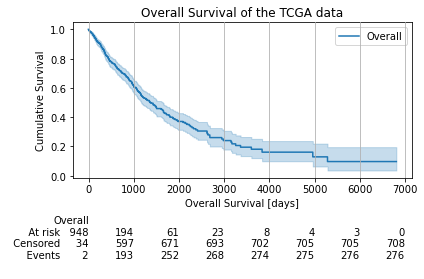

In [17]:
ax_TCGA = kmf_TCGA.plot_survival_function(at_risk_counts = True)
ax_TCGA.set(title = 'Overall Survival of the TCGA data', xlabel = 'Overall Survival [days]', ylabel = 'Cumulative Survival')
plt.grid(True)
plt.tight_layout()
plt.savefig('/Users/philipp/Documents/GitHub/CAS-2020-21/FIG_TCGAoverall.png', format = 'png')

In [19]:
median_TCGA = kmf_TCGA.median_survival_time_
CI_TCGA = median_survival_times(kmf_TCGA.confidence_interval_)
print(median_TCGA, CI_TCGA)

1357.0      Overall_lower_0.95  Overall_upper_0.95
0.5              1161.0              1640.0


/opt/anaconda3/envs/BeginProgramming/lib/python3.8/site-packages/lifelines/utils/__init__.py:1175: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/opt/anaconda3/envs/BeginProgramming/lib/python3.8/site-packages/lifelines/utils/__init__.py:1175: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/opt/anaconda3/envs/BeginProgramming/lib/python3.8/site-packages/lifelines/utils/__init__.py:1175: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning

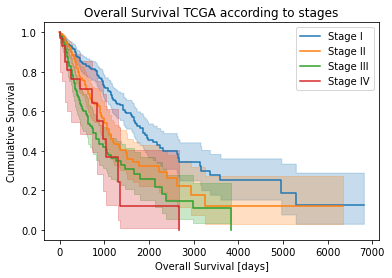

In [21]:
kmf = KaplanMeierFitter()

ax_TCGAstage = plt.subplot(111)

for name, grouped_df in TCGA_interesting.groupby('stage_short'):
    kmf.fit(grouped_df['last_contact_days_to'], grouped_df['STATOS'], label = name)
    kmf.plot_survival_function(ax = ax_TCGAstage)
    plt.title('Overall Survival TCGA according to stages')
    plt.xlabel('Overall Survival [days]')
    plt.ylabel('Cumulative Survival')

In [22]:
TCGA_interesting.stage_short.value_counts()

Stage I      509
Stage II     277
Stage III    165
Stage IV      33
Name: stage_short, dtype: int64

/opt/anaconda3/envs/BeginProgramming/lib/python3.8/site-packages/lifelines/utils/__init__.py:1175: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/opt/anaconda3/envs/BeginProgramming/lib/python3.8/site-packages/lifelines/utils/__init__.py:1175: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/opt/anaconda3/envs/BeginProgramming/lib/python3.8/site-packages/lifelines/utils/__init__.py:1175: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning

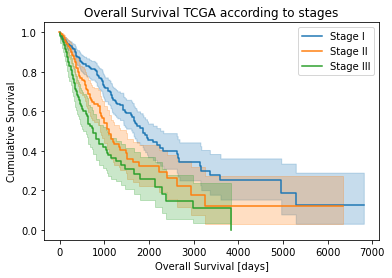

In [23]:
TCGA_reduced = TCGA_interesting[TCGA_interesting['stage_short'] != 'Stage IV']

ax_TCGAstage = plt.subplot(111)

for name, grouped_df in TCGA_reduced.groupby('stage_short'):
    kmf.fit(grouped_df['last_contact_days_to'], grouped_df['STATOS'], label = name)
    kmf.plot_survival_function(ax = ax_TCGAstage)
    plt.title('Overall Survival TCGA according to stages')
    plt.xlabel('Overall Survival [days]')
    plt.ylabel('Cumulative Survival')
    
plt.savefig('/Users/philipp/Documents/GitHub/CAS-2020-21/FIG_SurvivalTCGA.png', format = 'png')

In [24]:
TCGA_reduced['stage_short'] = TCGA_reduced['stage_short'].astype('category').cat.codes 
TCGA_reduced['last_contact_days_to'] = TCGA_reduced['last_contact_days_to'].astype('int64')

results_TCGA = multivariate_logrank_test(TCGA_reduced['last_contact_days_to'], TCGA_reduced['stage_short'], TCGA_reduced['STATOS'])
print('Statistics: {0:.2f}, p-value: {1:.3f}.'.format(results_TCGA.test_statistic, results_TCGA.p_value))

Statistics: 33.43, p-value: 0.000.


<ipython-input-24-06432099c5f3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TCGA_reduced['stage_short'] = TCGA_reduced['stage_short'].astype('category').cat.codes
<ipython-input-24-06432099c5f3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TCGA_reduced['last_contact_days_to'] = TCGA_reduced['last_contact_days_to'].astype('int64')


In [27]:
kmf_TCGAI = KaplanMeierFitter()
kmf_TCGAII = KaplanMeierFitter()
kmf_TCGAIII = KaplanMeierFitter()

TCGAI = TCGA_reduced.query('stage_short == 0')
TCGAII = TCGA_reduced.query('stage_short == 1')
TCGAIII = TCGA_reduced.query('stage_short == 2')

In [28]:
kmf_TCGAI.fit(durations = TCGAI['last_contact_days_to'], event_observed = TCGAI['STATOS'], label = 'Stage I')
kmf_TCGAII.fit(durations = TCGAII['last_contact_days_to'], event_observed = TCGAII['STATOS'], label = 'Stage II')
kmf_TCGAIII.fit(durations = TCGAIII['last_contact_days_to'], event_observed = TCGAIII['STATOS'], label = 'Stage III')

<lifelines.KaplanMeierFitter:"Stage III", fitted with 165 total observations, 93 right-censored observations>

In [29]:
OSMed_TCGAI = kmf_TCGAI.median_survival_time_
OSMed_TCGAII = kmf_TCGAII.median_survival_time_
OSMed_TCGAIII = kmf_TCGAIII.median_survival_time_
OSCI_TCGAI = median_survival_times(kmf_TCGAI.confidence_interval_)
OSCI_TCGAII = median_survival_times(kmf_TCGAII.confidence_interval_)
OSCI_TCGAIII = median_survival_times(kmf_TCGAIII.confidence_interval_)
print(OSMed_TCGAI, OSCI_TCGAI)
print(OSMed_TCGAII, OSCI_TCGAII)
print(OSMed_TCGAIII, OSCI_TCGAIII)

1874.0      Stage I_lower_0.95  Stage I_upper_0.95
0.5              1622.0              2318.0
1091.0      Stage II_lower_0.95  Stage II_upper_0.95
0.5                899.0               1492.0
740.0      Stage III_lower_0.95  Stage III_upper_0.95
0.5                 519.0                1057.0


## Comparison of the _study_ and _control_ cohort

In [30]:
# The control cohort does include only adeno- or squamous cell carcinomas. For comparison, we will thus exclude all neoadjuvant cases with other histology than LUAD or LUSC
df_comparison = df_valid[df_valid['HISTO'] < 3].dropna(subset = ['STATOS'])

### Categorical variables - data clean up & category merging

In [31]:
# Some of the categorical variables have a lot of small categories. We will look at these in order to decide which one to simplify
for column in df_comparison[['pT_TNM8', 'Stage_TNM8', 'SMOKING', 'RTYPE', 'R', 'ADJ']]:
    print(pd.crosstab(index = df_comparison[column], columns = df_comparison['group']))
    print()

group    Neoadjuvant  Primary
pT_TNM8                      
0.0               11        0
11.0              13        3
12.0              13        6
13.0              11        9
21.0              17       21
22.0               5       16
30.0              20       27
40.0              19       27

group       Neoadjuvant  Primary
Stage_TNM8                      
0.0                   6        0
111.0                10        0
112.0                 4        0
113.0                 4        0
120.0                 4        0
210.0                 2        0
220.0                23        0
310.0                33       47
320.0                17       52
330.0                 1        0
410.0                 4        9
420.0                 1        1

group    Neoadjuvant  Primary
SMOKING                      
0.0               13       13
1.0               34       33
2.0               49       40

group  Neoadjuvant  Primary
RTYPE                      
1.0              0        3
3

In [32]:
# Cases with no curative resection RTYPE = 1 or without any information about the completeness of the resection need to be excluded
df_testing = df_comparison[df_comparison['R'] != 3]
df_testing = df_testing[df_testing['RTYPE'] != 1]

In [33]:
# Most important pT categories are 0, 1, 2, 3 and 4. We don't need all other subcategories
conditions_pT = [
    (df_testing['pT_TNM8'] < 10),
    (df_testing['pT_TNM8'] < 20),
    (df_testing['pT_TNM8'] < 30),
    (df_testing['pT_TNM8'] < 40),
    (df_testing['pT_TNM8'] == 40)
]
values_pT = ['pT0', 'pT1', 'pT2', 'pT3', 'pT4']
df_testing['pT_short'] = np.select(conditions_pT, values_pT)

conditions_stage = [
    (df_testing['Stage_TNM8'] < 100),
    (df_testing['Stage_TNM8'] < 200),
    (df_testing['Stage_TNM8'] < 300),
    (df_testing['Stage_TNM8'] < 400),
    (df_testing['Stage_TNM8'] >= 400)
]
values_stage = ['Stage 0', 'Stage I', 'Stage II', 'Stage III', 'Stage IV']
df_testing['stage_short'] = np.select(conditions_stage, values_stage)

In [34]:
# Upper or lower bilobectomy are equally extensive, hence, we combine these
conditions_RTYPE = [
    (df_testing['RTYPE'] == 3),
    (df_testing['RTYPE'] < 6),
    (df_testing['RTYPE'] == 6)
]
values_RTYPE = [1, 2, 3]
df_testing['rtype_short'] = np.select(conditions_RTYPE, values_RTYPE)

conditions_R = [
    (df_testing['R'] == 0),
    (df_testing['R'] > 0)
]
values_R = [0, 1]
df_testing['R_short'] = np.select(conditions_R, values_R)

In [35]:
# We are only interested if the patients received adjuvant therapy after resection or not
conditions_adjuvant = [
    (df_testing['ADJ'] == 0),
    (df_testing['ADJ'] < 4),
    (df_testing['ADJ'] == 4),
    (df_testing['ADJ'] == 5)
]
values_adjuvant = [0, 1, 0, 1]

df_testing['adjuvant_short'] = np.select(conditions_adjuvant, values_adjuvant)
df_testing

,PID,AGE,SEX,SMOKING,HISTO,BED,VITAL,pT_TNM8,pN_TNM8,pM_TNM8,Stage_TNM8,REG,NEOCAT,NEOCTX,NEOCYCLES,NEOCTXCHANGE,NEORTX,NEOSTART,NEOSTOP,RESECTION,RTYPE,R,ADJ,RELAPSE,RELDATE,STATOS,STATDFS,ED,LFU,start_date,stop_date_OS,OS,group,pT_short,stage_short,rtype_short,R_short,adjuvant_short
1,2,74.0,2.0,NaN,2,4.5,90.0,22.0,211.0,0,310.0,4.0,0,1.0,4.0,2.0,0.0,14.02.01,11.04.01,10.05.01,3.0,0.0,4.0,2.0,03.12.01,1.0,1.0,14.02.01,22.07.02,2001-02-14,2002-07-22,17.183104,Neoadjuvant,pT2,Stage III,1,0,0
2,4,76.0,2.0,2.0,1,3.0,0.5,13.0,12.0,0,220.0,1.0,1,1.0,3.0,0.0,1.0,06.10.03,09.12.03,05.02.04,6.0,1.0,0.0,NaN,NaN,0.0,0.0,06.10.03,22.03.04,2003-10-06,2004-03-22,5.519621,Neoadjuvant,pT1,Stage II,3,1,0
3,5,77.0,2.0,2.0,1,2.3,20.0,40.0,11.0,0,310.0,3.0,1,1.0,3.0,1.0,0.0,17.08.05,19.10.05,03.11.05,4.0,1.0,NaN,0.0,NaN,1.0,1.0,17.08.05,14.12.05,2005-08-17,2005-12-14,3.909731,Neoadjuvant,pT4,Stage III,2,1,0
4,6,77.0,2.0,NaN,2,2.3,80.0,13.0,211.0,0,310.0,4.0,0,NaN,NaN,NaN,NaN,NaN,NaN,03.08.06,3.0,0.0,NaN,0.0,NaN,1.0,1.0,03.08.06,07.08.06,2006-08-03,2006-08-07,0.131420,Neoadjuvant,pT1,Stage III,1,0,0
5,7,72.0,2.0,2.0,1,9.0,90.0,40.0,22.0,0,320.0,4.0,1,9.0,3.0,0.0,NaN,18.04.02,05.06.02,04.07.02,3.0,1.0,0.0,0.0,NaN,1.0,1.0,18.04.02,10.09.02,2002-04-18,2002-09-10,4.763958,Neoadjuvant,pT4,Stage III,1,1,0
6,8,70.0,2.0,2.0,1,13.0,5.0,40.0,0.0,0,310.0,2.0,0,9.0,3.0,0.0,1.0,01.07.00,01.08.00,21.09.00,3.0,0.0,0.0,1.0,25.05.01,0.0,1.0,01.07.00,20.08.02,2000-07-01,2002-08-20,25.626810,Neoadjuvant,pT4,Stage III,1,0,0
7,9,70.0,2.0,2.0,1,3.5,95.0,21.0,11.0,0,220.0,4.0,1,1.0,3.0,1.0,0.0,25.05.00,01.08.00,14.08.00,6.0,0.0,0.0,0.0,NaN,1.0,1.0,25.05.00,11.09.00,2000-05-25,2000-09-11,3.581182,Neoadjuvant,pT2,Stage II,3,0,0
8,10,72.0,2.0,1.0,1,6.0,95.0,30.0,12.0,0,310.0,4.0,0,3.0,3.0,0.0,NaN,14.11.03,06.01.04,23.01.04,3.0,0.0,NaN,NaN,NaN,0.0,0.0,14.11.03,07.03.05,2003-11-14,2005-03-07,15.737489,Neoadjuvant,pT3,Stage III,1,0,0
9,11,71.0,2.0,2.0,2,4.0,0.5,30.0,0.0,0,220.0,1.0,1,9.0,8.0,2.0,1.0,01.10.02,18.11.02,24.01.03,3.0,0.0,0.0,NaN,NaN,0.0,0.0,01.10.02,20.02.03,2002-10-01,2003-02-20,4.665394,Neoadjuvant,pT3,Stage II,1,0,0
10,12,70.0,1.0,2.0,1,3.0,9.0,13.0,0.0,0,113.0,2.0,0,3.0,3.0,0.0,0.0,18.12.02,25.02.03,20.02.03,3.0,0.0,0.0,0.0,NaN,1.0,1.0,18.12.02,06.06.17,2002-12-18,2017-06-06,173.605207,Neoadjuvant,pT1,Stage I,1,0,0


### Categorical variables - testing

In [36]:
# pT- and stage-variable have a natural order (higher categories = more aggressive). We use the Mann-Whitney-U
df_testing_study = df_testing[df_testing['group'] == 'Neoadjuvant']
df_testing_control = df_testing[df_testing['group'] == 'Primary']

for column in df_testing[['pT_short', 'stage_short']]:
    stat, p = scipy.stats.mannwhitneyu(df_testing_study[column], df_testing_control[column])
    print('Statistics = {0:.2f}, p-value = {1:.3f}'.format(stat, p))

Statistics = 4039.00, p-value = 0.000
Statistics = 2773.00, p-value = 0.000


In [37]:
# The difference could probably be explained by the fact that treated cases can have no more tumor. Hence, we exclude cases with pT0 or stage 0
df_testing_withoutpT0 = df_testing[df_testing['pT_short'] != 'pT0']
df_testing_study_withoutpT0 = df_testing_withoutpT0[df_testing['group'] == 'Neoadjuvant']
df_testing_control_withoutpT0 = df_testing_withoutpT0[df_testing['group'] == 'Primary']

df_testing_withoutstage0 = df_testing[df_testing['stage_short'] != 'Stage 0']
df_testing_study_withoutstage0 = df_testing_withoutstage0[df_testing['group'] == 'Neoadjuvant']
df_testing_control_withoutstage0 = df_testing_withoutstage0[df_testing['group'] == 'Primary']

stat_pT, p_pT = scipy.stats.mannwhitneyu(df_testing_study_withoutpT0['pT_short'], df_testing_control_withoutpT0['pT_short'])
print('Statistics = {0:.2f}, p-value = {1:.3f}'.format(stat_pT, p_pT))

stat_stage, p_stage = scipy.stats.mannwhitneyu(df_testing_study_withoutstage0['stage_short'], df_testing_control_withoutstage0['stage_short'])
print('Statistics = {0:.2f}, p-value = {1:.3f}'.format(stat_stage, p_stage))

Statistics = 4039.00, p-value = 0.008
Statistics = 2773.00, p-value = 0.000


<ipython-input-37-b2cd257f5ac7>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_testing_study_withoutpT0 = df_testing_withoutpT0[df_testing['group'] == 'Neoadjuvant']
<ipython-input-37-b2cd257f5ac7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_testing_control_withoutpT0 = df_testing_withoutpT0[df_testing['group'] == 'Primary']
<ipython-input-37-b2cd257f5ac7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_testing_study_withoutstage0 = df_testing_withoutstage0[df_testing['group'] == 'Neoadjuvant']
<ipython-input-37-b2cd257f5ac7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_testing_control_withoutstage0 = df_testing_withoutstage0[df_testing['group'] == 'Primary']


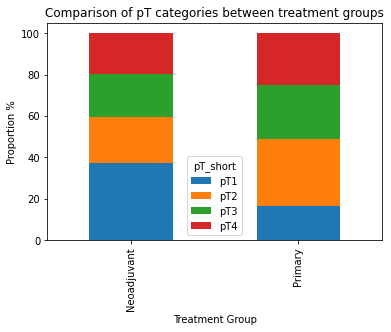

In [38]:
crosstab_pT = pd.crosstab(index = df_testing_withoutpT0['group'], columns = df_testing_withoutpT0['pT_short'])
crosstab_proportion_pT = crosstab_pT.apply(lambda x: x*100/sum(x), axis=1)
crosstab_proportion_pT.plot.bar(stacked=True)
plt.xlabel('Treatment Group')
plt.ylabel('Proportion %')
plt.title('Comparison of pT categories between treatment groups')
plt.savefig('/Users/philipp/Documents/GitHub/CAS-2020-21/FIG_pTcomparison.png', format = 'png')

Text(0.5, 1.0, 'Comparison of stage categories between treatment groups')

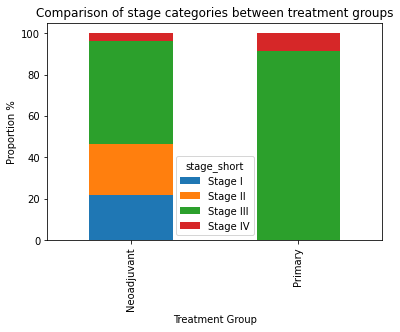

In [39]:
crosstab_stage = pd.crosstab(index = df_testing_withoutstage0['group'], columns = df_testing_withoutstage0['stage_short'])
crosstab_proportion_stage = crosstab_stage.apply(lambda x: x*100/sum(x), axis=1)
crosstab_proportion_stage.plot.bar(stacked=True)
plt.xlabel('Treatment Group')
plt.ylabel('Proportion %')
plt.title('Comparison of stage categories between treatment groups')

In [40]:
# Completeness of resection and adjuvant therapy are binary -> Fisher's exact
# Adjuvant therapy
crosstab_adjuvant = pd.crosstab(index = df_testing['adjuvant_short'], columns = df_testing['group'])
fisher_table_adjuvant = crosstab_adjuvant.to_numpy()
stats_adjuvant, p_adjuvant = scipy.stats.fisher_exact(fisher_table_adjuvant)

print('Adjuvant Statistic: {0:.2f}, Adjuvant p-value: {1:.3f}'.format(stats_adjuvant, p_adjuvant))
crosstab_adjuvant

Adjuvant Statistic: 5.48, Adjuvant p-value: 0.000


group,Neoadjuvant,Primary
adjuvant_short,,
0,85,43
1,22,61


In [41]:
# Completeness of resection
crosstab_R = pd.crosstab(index = df_testing['R_short'], columns = df_testing['group'])
fisher_table_R = crosstab_R.to_numpy()
stats_R, p_R = scipy.stats.fisher_exact(fisher_table_R)

print('Completeness Statistic: {0:.2f}, Completeness p-value: {1:.3f}'.format(stats_R, p_R))
crosstab_R

Completeness Statistic: 1.94, Completeness p-value: 0.079


group,Neoadjuvant,Primary
R_short,,
0,92,79
1,15,25


In [42]:
# Resection type and smoking status are categorical without order -> Chi^2 test
# Smoking
crosstab_Smoking = pd.crosstab(index = df_testing['SMOKING'], columns = df_testing['group'])
chisquare_table_Smoking = crosstab_Smoking.to_numpy()
chi2_Smoking, p_Smoking, dof, expected = scipy.stats.chi2_contingency(chisquare_table_Smoking)

print('Smoking Statistic: {0:.2f}, Smoking p-value: {1:.3f}'.format(chi2_Smoking, p_Smoking))
crosstab_Smoking

Smoking Statistic: 0.13, Smoking p-value: 0.936


group,Neoadjuvant,Primary
SMOKING,,
0.0,12,11
1.0,33,30
2.0,49,40


In [43]:
# Resection type
crosstab_Rtype = pd.crosstab(index = df_testing['rtype_short'], columns = df_testing['group'])
chisquare_table_Rtype = crosstab_Rtype.to_numpy()
chi2_Rtype, p_Rtype, dof, expected = scipy.stats.chi2_contingency(chisquare_table_Rtype)

print('Smoking Statistic: {0:.2f}, Smoking p-value: {1:.3f}'.format(chi2_Rtype, p_Rtype))
crosstab_Rtype

Smoking Statistic: 0.83, Smoking p-value: 0.660


group,Neoadjuvant,Primary
rtype_short,,
1,65,61
2,5,8
3,37,35


### Continuous variables - testing

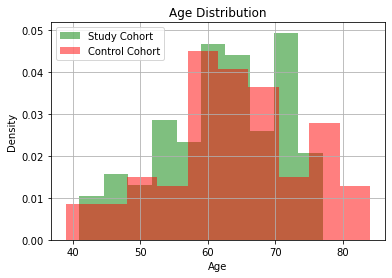

In [44]:
# First visually check if the data is normally distributed
ax_1 = plt.hist(df_testing_study['AGE'], 10, density = 1, facecolor = 'g', alpha = 0.5, label = 'Study Cohort')
ax_2 = plt.hist(df_testing_control['AGE'], 10, density = 1, facecolor = 'r', alpha = 0.5, label = 'Control Cohort')
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Age Distribution')
plt.grid(True)
plt.legend()
plt.savefig('/Users/philipp/Documents/GitHub/CAS-2020-21/FIG_agecomparison.png', format = 'png')

In [45]:
# We check if it's possible to use the students t or if we need to use the Welch
var_study = np.var(df_testing_study['AGE'])
mean_study = np.mean(df_testing_study['AGE'])
size_study = len(df_testing_study.index)
var_control = np.var(df_testing_control['AGE'])
mean_control = np.mean(df_testing_control['AGE'])
size_control = len(df_testing_control.index)

print('The study cohort has a mean age of {0:.2f} and a variance of {1:.2f}. A total of {2} cases.'.format(mean_study, var_study, size_study))
print('The control cohort has a mean age of {0:.2f} and a variance of {1:.2f}. A total of {2} cases.'.format(mean_control, var_control, size_control))

The study cohort has a mean age of 61.95 and a variance of 78.59. A total of 107 cases.
The control cohort has a mean age of 63.63 and a variance of 100.14. A total of 104 cases.


In [46]:
# All requirements are fulfilled -> perform the statistical test
stats_age, p_age = scipy.stats.ttest_ind(df_testing_study['AGE'], df_testing_control['AGE'])
print('Statistics = {0:.2f} and p-value = {1:.3f}'.format(stats_age, p_age))

Statistics = -1.29 and p-value = 0.200


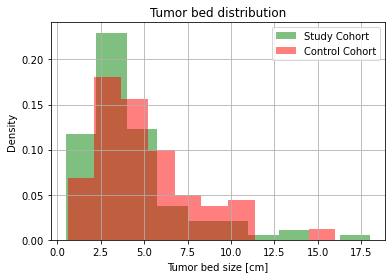

In [47]:
# Visually check normal distribution
ax_histobed1 = plt.hist(df_testing_study['BED'], 10, density = 1, facecolor = 'g', alpha = 0.5, label = 'Study Cohort')
ax_histobed2 = plt.hist(df_testing_control['BED'], 10, density = 1, facecolor = 'r', alpha = 0.5, label = 'Control Cohort')
plt.xlabel('Tumor bed size [cm]')
plt.ylabel('Density')
plt.title('Tumor bed distribution')
plt.grid(True)
plt.legend()

In [48]:
# Requirement of normal distribution is not fulfilled
stats_bed, p_bed = scipy.stats.mannwhitneyu(df_testing_study['BED'], df_testing_control['BED'])
print('Statistics = {0:.2f} and p-value = {1:.3f}'.format(stats_bed, p_bed))

Statistics = 4246.00 and p-value = 0.001


/opt/anaconda3/envs/BeginProgramming/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


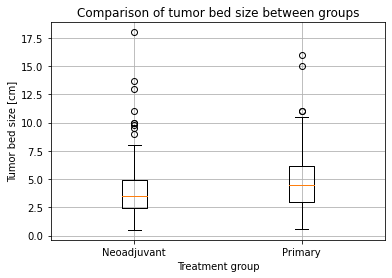

In [49]:
# There is a statistical difference, however, the non-parametric tests are significance driven -> visual check
data_boxplot = [df_testing_study['BED'], df_testing_control['BED']]
fig_box, ax_box = plt.subplots()
ax_box.set_title('Comparison of tumor bed size between groups')
ax_box.boxplot(data_boxplot, labels = ['Neoadjuvant', 'Primary'])
plt.xlabel('Treatment group')
plt.ylabel('Tumor bed size [cm]')
plt.grid(True)
plt.savefig('/Users/philipp/Documents/GitHub/CAS-2020-21/FIG_sizecomparison.png', format = 'png')

### Survival comparison

In [51]:
kmf_comparison = KaplanMeierFitter()
kmf_comparison.fit(durations = df_testing['OS'], event_observed = df_testing['STATOS'], label = 'Overall')

<lifelines.KaplanMeierFitter:"Overall", fitted with 211 total observations, 85 right-censored observations>

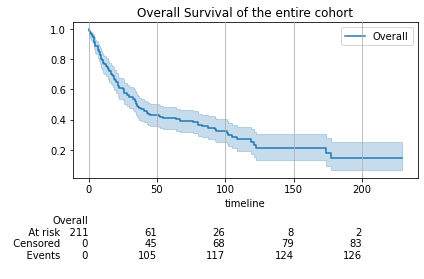

In [52]:
kmf_comparison.plot_survival_function(at_risk_counts = True)
plt.title('Overall Survival of the entire cohort')
plt.grid(True)
plt.tight_layout()

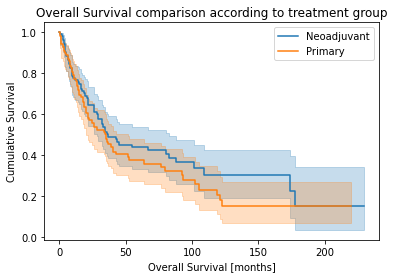

In [54]:
kmf = KaplanMeierFitter()

ax_comparison = plt.subplot(111)

for name, grouped_df in df_testing.groupby('group'):
    kmf.fit(grouped_df['OS'], grouped_df['STATOS'], label = name)
    kmf.plot_survival_function(ax = ax_comparison)
    plt.title('Overall Survival comparison according to treatment group')
    plt.xlabel('Overall Survival [months]')
    plt.ylabel('Cumulative Survival')

In [55]:
# From the Kaplan-Meier plot it seems that neoadjuvant cases have a better survival -> let's test it
results_comparison = multivariate_logrank_test(df_testing['OS'], df_testing['group'], df_testing['STATOS'])
print('Statistics: {0:.2f}, p-value: {1:.3f}.'.format(results_comparison.test_statistic, results_comparison.p_value))

Statistics: 1.08, p-value: 0.298.


In [56]:
kmf_neo = KaplanMeierFitter()
kmf_prim = KaplanMeierFitter()

In [57]:
Neo = df_testing.query('group == "Neoadjuvant"')
Prim = df_testing.query('group == "Primary"')

In [58]:
kmf_neo.fit(durations = Neo['OS'], event_observed = Neo['STATOS'], label = 'Neoadjuvant')
kmf_prim.fit(durations = Prim['OS'], event_observed = Prim['STATOS'], label = 'Primary')

<lifelines.KaplanMeierFitter:"Primary", fitted with 104 total observations, 38 right-censored observations>

In [59]:
OSMed_neo = kmf_neo.median_survival_time_
OSMed_prim = kmf_prim.median_survival_time_
OSCI_neo = median_survival_times(kmf_neo.confidence_interval_)
OSCI_prim = median_survival_times(kmf_prim.confidence_interval_)
print(OSMed_neo, OSCI_neo)
print(OSMed_prim, OSCI_prim)

36.86317994209327      Neoadjuvant_lower_0.95  Neoadjuvant_upper_0.95
0.5               28.222345               82.695743
34.82617712889382      Primary_lower_0.95  Primary_upper_0.95
0.5           20.140044           51.385039


## Survival prediction for neoadjuvant cases

In [60]:
df_study_survivalanalyses = df_valid[df_valid['group'] == 'Neoadjuvant'].dropna(subset = ['VITAL', 'STATOS'])
df_study_survivalanalyses = df_study_survivalanalyses[df_study_survivalanalyses['Stage_TNM8'] < 400]
df_study_survivalanalyses

,PID,AGE,SEX,SMOKING,HISTO,BED,VITAL,pT_TNM8,pN_TNM8,pM_TNM8,Stage_TNM8,REG,NEOCAT,NEOCTX,NEOCYCLES,NEOCTXCHANGE,NEORTX,NEOSTART,NEOSTOP,RESECTION,RTYPE,R,ADJ,RELAPSE,RELDATE,STATOS,STATDFS,ED,LFU,start_date,stop_date_OS,OS,group
1,2,74.0,2.0,NaN,2,4.5,90.0,22.0,211.0,0,310.0,4.0,0,1.0,4.0,2.0,0.0,14.02.01,11.04.01,10.05.01,3.0,0.0,4.0,2.0,03.12.01,1.0,1.0,14.02.01,22.07.02,2001-02-14,2002-07-22,17.183104,Neoadjuvant
2,4,76.0,2.0,2.0,1,3.0,0.5,13.0,12.0,0,220.0,1.0,1,1.0,3.0,0.0,1.0,06.10.03,09.12.03,05.02.04,6.0,1.0,0.0,NaN,NaN,0.0,0.0,06.10.03,22.03.04,2003-10-06,2004-03-22,5.519621,Neoadjuvant
3,5,77.0,2.0,2.0,1,2.3,20.0,40.0,11.0,0,310.0,3.0,1,1.0,3.0,1.0,0.0,17.08.05,19.10.05,03.11.05,4.0,1.0,NaN,0.0,NaN,1.0,1.0,17.08.05,14.12.05,2005-08-17,2005-12-14,3.909731,Neoadjuvant
4,6,77.0,2.0,NaN,2,2.3,80.0,13.0,211.0,0,310.0,4.0,0,NaN,NaN,NaN,NaN,NaN,NaN,03.08.06,3.0,0.0,NaN,0.0,NaN,1.0,1.0,03.08.06,07.08.06,2006-08-03,2006-08-07,0.131420,Neoadjuvant
5,7,72.0,2.0,2.0,1,9.0,90.0,40.0,22.0,0,320.0,4.0,1,9.0,3.0,0.0,NaN,18.04.02,05.06.02,04.07.02,3.0,1.0,0.0,0.0,NaN,1.0,1.0,18.04.02,10.09.02,2002-04-18,2002-09-10,4.763958,Neoadjuvant
6,8,70.0,2.0,2.0,1,13.0,5.0,40.0,0.0,0,310.0,2.0,0,9.0,3.0,0.0,1.0,01.07.00,01.08.00,21.09.00,3.0,0.0,0.0,1.0,25.05.01,0.0,1.0,01.07.00,20.08.02,2000-07-01,2002-08-20,25.626810,Neoadjuvant
7,9,70.0,2.0,2.0,1,3.5,95.0,21.0,11.0,0,220.0,4.0,1,1.0,3.0,1.0,0.0,25.05.00,01.08.00,14.08.00,6.0,0.0,0.0,0.0,NaN,1.0,1.0,25.05.00,11.09.00,2000-05-25,2000-09-11,3.581182,Neoadjuvant
8,10,72.0,2.0,1.0,1,6.0,95.0,30.0,12.0,0,310.0,4.0,0,3.0,3.0,0.0,NaN,14.11.03,06.01.04,23.01.04,3.0,0.0,NaN,NaN,NaN,0.0,0.0,14.11.03,07.03.05,2003-11-14,2005-03-07,15.737489,Neoadjuvant
9,11,71.0,2.0,2.0,2,4.0,0.5,30.0,0.0,0,220.0,1.0,1,9.0,8.0,2.0,1.0,01.10.02,18.11.02,24.01.03,3.0,0.0,0.0,NaN,NaN,0.0,0.0,01.10.02,20.02.03,2002-10-01,2003-02-20,4.665394,Neoadjuvant
10,12,70.0,1.0,2.0,1,3.0,9.0,13.0,0.0,0,113.0,2.0,0,3.0,3.0,0.0,0.0,18.12.02,25.02.03,20.02.03,3.0,0.0,0.0,0.0,NaN,1.0,1.0,18.12.02,06.06.17,2002-12-18,2017-06-06,173.605207,Neoadjuvant


In [61]:
# Age, stage, type of resection, completeness of resection and pathological response could be important prognostic factors
conditions_stage = [
    (df_study_survivalanalyses['Stage_TNM8'] < 100),
    (df_study_survivalanalyses['Stage_TNM8'] < 200),
    (df_study_survivalanalyses['Stage_TNM8'] < 300),
    (df_study_survivalanalyses['Stage_TNM8'] < 400)
]
values_stage = ['Stage 0', 'Stage I', 'Stage II', 'Stage III']
df_study_survivalanalyses['stage_short'] = np.select(conditions_stage, values_stage)

conditions_RTYPE = [
    (df_study_survivalanalyses['RTYPE'] == 3),
    (df_study_survivalanalyses['RTYPE'] < 6),
    (df_study_survivalanalyses['RTYPE'] == 6)
]
values_RTYPE = [1, 2, 3]
df_study_survivalanalyses['rtype_short'] = np.select(conditions_RTYPE, values_RTYPE)

conditions_R = [
    (df_study_survivalanalyses['R'] == 0),
    (df_study_survivalanalyses['R'] > 0)
]
values_R = [0, 1]
df_study_survivalanalyses['R_short'] = np.select(conditions_R, values_R)

# Let's create a variable which defines major pathological response based on the histology
df_study_survivalanalyses['MPR'] = ((df_study_survivalanalyses['HISTO'] == 2) & (df_study_survivalanalyses['VITAL'] <= 65)) | ((df_study_survivalanalyses['HISTO'] != 2) & (df_study_survivalanalyses['VITAL'] <= 10))
conditions_MPR = [
    (df_study_survivalanalyses['MPR'] == True),
    (df_study_survivalanalyses['MPR'] != True)
]
values_MPR = ['MPR', 'No-MPR']
df_study_survivalanalyses['MPR'] = np.select(conditions_MPR, values_MPR)
df_study_survivalanalyses

,PID,AGE,SEX,SMOKING,HISTO,BED,VITAL,pT_TNM8,pN_TNM8,pM_TNM8,Stage_TNM8,REG,NEOCAT,NEOCTX,NEOCYCLES,NEOCTXCHANGE,NEORTX,NEOSTART,NEOSTOP,RESECTION,RTYPE,R,ADJ,RELAPSE,RELDATE,STATOS,STATDFS,ED,LFU,start_date,stop_date_OS,OS,group,stage_short,rtype_short,R_short,MPR
1,2,74.0,2.0,NaN,2,4.5,90.0,22.0,211.0,0,310.0,4.0,0,1.0,4.0,2.0,0.0,14.02.01,11.04.01,10.05.01,3.0,0.0,4.0,2.0,03.12.01,1.0,1.0,14.02.01,22.07.02,2001-02-14,2002-07-22,17.183104,Neoadjuvant,Stage III,1,0,No-MPR
2,4,76.0,2.0,2.0,1,3.0,0.5,13.0,12.0,0,220.0,1.0,1,1.0,3.0,0.0,1.0,06.10.03,09.12.03,05.02.04,6.0,1.0,0.0,NaN,NaN,0.0,0.0,06.10.03,22.03.04,2003-10-06,2004-03-22,5.519621,Neoadjuvant,Stage II,3,1,MPR
3,5,77.0,2.0,2.0,1,2.3,20.0,40.0,11.0,0,310.0,3.0,1,1.0,3.0,1.0,0.0,17.08.05,19.10.05,03.11.05,4.0,1.0,NaN,0.0,NaN,1.0,1.0,17.08.05,14.12.05,2005-08-17,2005-12-14,3.909731,Neoadjuvant,Stage III,2,1,No-MPR
4,6,77.0,2.0,NaN,2,2.3,80.0,13.0,211.0,0,310.0,4.0,0,NaN,NaN,NaN,NaN,NaN,NaN,03.08.06,3.0,0.0,NaN,0.0,NaN,1.0,1.0,03.08.06,07.08.06,2006-08-03,2006-08-07,0.131420,Neoadjuvant,Stage III,1,0,No-MPR
5,7,72.0,2.0,2.0,1,9.0,90.0,40.0,22.0,0,320.0,4.0,1,9.0,3.0,0.0,NaN,18.04.02,05.06.02,04.07.02,3.0,1.0,0.0,0.0,NaN,1.0,1.0,18.04.02,10.09.02,2002-04-18,2002-09-10,4.763958,Neoadjuvant,Stage III,1,1,No-MPR
6,8,70.0,2.0,2.0,1,13.0,5.0,40.0,0.0,0,310.0,2.0,0,9.0,3.0,0.0,1.0,01.07.00,01.08.00,21.09.00,3.0,0.0,0.0,1.0,25.05.01,0.0,1.0,01.07.00,20.08.02,2000-07-01,2002-08-20,25.626810,Neoadjuvant,Stage III,1,0,MPR
7,9,70.0,2.0,2.0,1,3.5,95.0,21.0,11.0,0,220.0,4.0,1,1.0,3.0,1.0,0.0,25.05.00,01.08.00,14.08.00,6.0,0.0,0.0,0.0,NaN,1.0,1.0,25.05.00,11.09.00,2000-05-25,2000-09-11,3.581182,Neoadjuvant,Stage II,3,0,No-MPR
8,10,72.0,2.0,1.0,1,6.0,95.0,30.0,12.0,0,310.0,4.0,0,3.0,3.0,0.0,NaN,14.11.03,06.01.04,23.01.04,3.0,0.0,NaN,NaN,NaN,0.0,0.0,14.11.03,07.03.05,2003-11-14,2005-03-07,15.737489,Neoadjuvant,Stage III,1,0,No-MPR
9,11,71.0,2.0,2.0,2,4.0,0.5,30.0,0.0,0,220.0,1.0,1,9.0,8.0,2.0,1.0,01.10.02,18.11.02,24.01.03,3.0,0.0,0.0,NaN,NaN,0.0,0.0,01.10.02,20.02.03,2002-10-01,2003-02-20,4.665394,Neoadjuvant,Stage II,1,0,MPR
10,12,70.0,1.0,2.0,1,3.0,9.0,13.0,0.0,0,113.0,2.0,0,3.0,3.0,0.0,0.0,18.12.02,25.02.03,20.02.03,3.0,0.0,0.0,0.0,NaN,1.0,1.0,18.12.02,06.06.17,2002-12-18,2017-06-06,173.605207,Neoadjuvant,Stage I,1,0,MPR


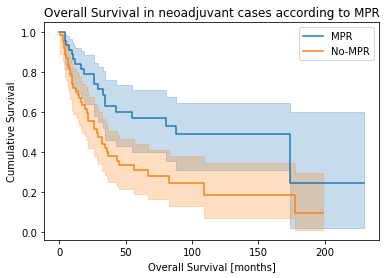

In [62]:
# Cases with MPR should have a better survival
ax_MPR = plt.subplot(111)

for name, grouped_df in df_study_survivalanalyses.groupby('MPR'):
    kmf.fit(grouped_df['OS'], grouped_df['STATOS'], label = name)
    kmf.plot_survival_function(ax = ax_MPR)
    plt.title('Overall Survival in neoadjuvant cases according to MPR')
    plt.xlabel('Overall Survival [months]')
    plt.ylabel('Cumulative Survival')
plt.savefig('/Users/philipp/Documents/GitHub/CAS-2020-21/FIG_MPR.png', format = 'png')

In [63]:
results_MPR = multivariate_logrank_test(df_study_survivalanalyses['OS'], df_study_survivalanalyses['MPR'], df_study_survivalanalyses['STATOS'])
print('Statistics: {0:.2f}, p-value: {1:.3f}.'.format(results_MPR.test_statistic, results_MPR.p_value))

Statistics: 7.60, p-value: 0.006.


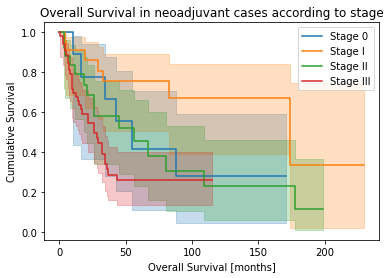

In [64]:
# Cases with lower stages should have better survival
ax_stage = plt.subplot(111)

for name, grouped_df in df_study_survivalanalyses.groupby('stage_short'):
    kmf.fit(grouped_df['OS'], grouped_df['STATOS'], label = name)
    kmf.plot_survival_function(ax = ax_stage)
    plt.title('Overall Survival in neoadjuvant cases according to stage')
    plt.xlabel('Overall Survival [months]')
    plt.ylabel('Cumulative Survival')

In [65]:
results_stage = multivariate_logrank_test(df_study_survivalanalyses['OS'], df_study_survivalanalyses['stage_short'], df_study_survivalanalyses['STATOS'])
print('Statistics: {0:.2f}, p-value: {1:.3f}.'.format(results_stage.test_statistic, results_stage.p_value))

Statistics: 11.61, p-value: 0.009.


Stage III    53
Stage II     26
Stage I      22
Stage 0      10
Name: stage_short, dtype: int64


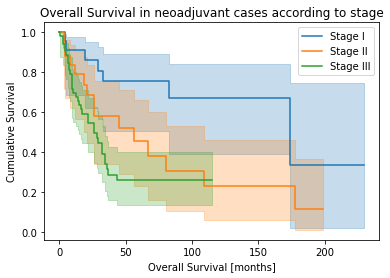

In [66]:
# The Stage 0 cases fall a little bit out of order... How many cases are there? More appropriate without Stage 0 cases?
print(df_study_survivalanalyses.stage_short.value_counts())
df_study_survivalanalyses_withoutStage0 = df_study_survivalanalyses[df_study_survivalanalyses['stage_short'] != 'Stage 0']
ax_stage_new = plt.subplot(111)

for name, grouped_df in df_study_survivalanalyses_withoutStage0.groupby('stage_short'):
    kmf.fit(grouped_df['OS'], grouped_df['STATOS'], label = name)
    kmf.plot_survival_function(ax = ax_stage_new)
    plt.title('Overall Survival in neoadjuvant cases according to stage')
    plt.xlabel('Overall Survival [months]')
    plt.ylabel('Cumulative Survival')

In [67]:
results_stage = multivariate_logrank_test(df_study_survivalanalyses['OS'], df_study_survivalanalyses['stage_short'], df_study_survivalanalyses['STATOS'])
print('Statistics: {0:.2f}, p-value: {1:.3f}.'.format(results_stage.test_statistic, results_stage.p_value))

Statistics: 11.61, p-value: 0.009.


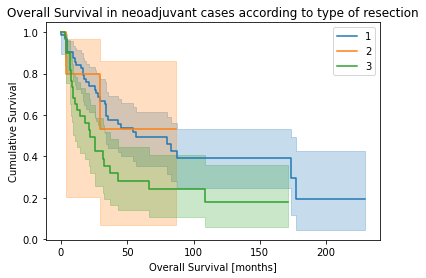

In [68]:
# Cases with less extensive resection should have better survival
ax_rtype = plt.subplot(111)

for name, grouped_df in df_study_survivalanalyses.groupby('rtype_short'):
    kmf.fit(grouped_df['OS'], grouped_df['STATOS'], label = name)
    kmf.plot_survival_function(ax = ax_rtype)
    plt.title('Overall Survival in neoadjuvant cases according to type of resection')
    plt.xlabel('Overall Survival [months]')
    plt.ylabel('Cumulative Survival')

In [69]:
results_Rtype = multivariate_logrank_test(df_study_survivalanalyses['OS'], df_study_survivalanalyses['rtype_short'], df_study_survivalanalyses['STATOS'])
print('Statistics: {0:.2f}, p-value: {1:.3f}.'.format(results_Rtype.test_statistic, results_Rtype.p_value))

Statistics: 6.44, p-value: 0.040.


1    66
3    40
2     5
Name: rtype_short, dtype: int64


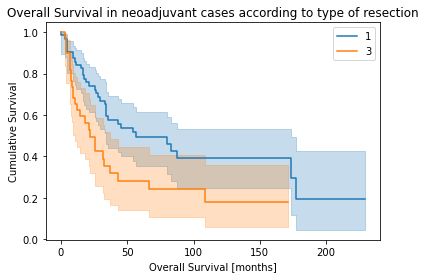

In [70]:
# Their seem to be much less bilobectomy cases. How much are their? Redo the Kaplan-Meier without considering Bilobectomy cases
print(df_study_survivalanalyses.rtype_short.value_counts())
df_study_survivalanalyses_withoutBilo = df_study_survivalanalyses[df_study_survivalanalyses['rtype_short'] != 2]
ax_rtype_new = plt.subplot(111)

for name, grouped_df in df_study_survivalanalyses_withoutBilo.groupby('rtype_short'):
    kmf.fit(grouped_df['OS'], grouped_df['STATOS'], label = name)
    kmf.plot_survival_function(ax = ax_rtype_new)
    plt.title('Overall Survival in neoadjuvant cases according to type of resection')
    plt.xlabel('Overall Survival [months]')
    plt.ylabel('Cumulative Survival')

In [71]:
results_Rtype = multivariate_logrank_test(df_study_survivalanalyses['OS'], df_study_survivalanalyses['rtype_short'], df_study_survivalanalyses['STATOS'])
print('Statistics: {0:.2f}, p-value: {1:.3f}.'.format(results_Rtype.test_statistic, results_Rtype.p_value))

Statistics: 6.44, p-value: 0.040.


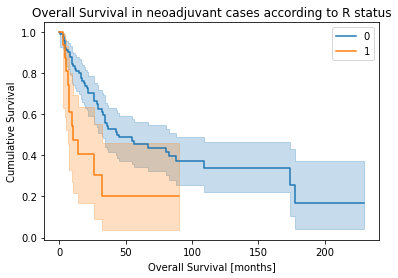

In [72]:
# Cases without residual tumor after surgery should have better survival
ax_R = plt.subplot(111)

for name, grouped_df in df_study_survivalanalyses.groupby('R_short'):
    kmf.fit(grouped_df['OS'], grouped_df['STATOS'], label = name)
    kmf.plot_survival_function(ax = ax_R)
    plt.title('Overall Survival in neoadjuvant cases according to R status')
    plt.xlabel('Overall Survival [months]')
    plt.ylabel('Cumulative Survival')

In [73]:
results_R = multivariate_logrank_test(df_study_survivalanalyses['OS'], df_study_survivalanalyses['R_short'], df_study_survivalanalyses['STATOS'])
print('Statistics: {0:.2f}, p-value: {1:.3f}.'.format(results_R.test_statistic, results_R.p_value))

Statistics: 7.98, p-value: 0.005.


In [74]:
df_study_survivalanalyses['MPR'] = df_study_survivalanalyses['MPR'].astype('category').cat.codes
df_study_survivalanalyses['stage_short'] = df_study_survivalanalyses['stage_short'].astype('category').cat.codes
df_study_survivalanalyses['SMOKING'] = df_study_survivalanalyses['SMOKING'].astype('category').cat.codes

In [75]:
df_study_survivalanalyses.dtypes

PID                      int64
AGE                    float64
SEX                    float64
SMOKING                   int8
HISTO                    int64
BED                    float64
VITAL                  float64
pT_TNM8                float64
pN_TNM8                float64
pM_TNM8                  int64
Stage_TNM8             float64
REG                    float64
NEOCAT                   int64
NEOCTX                 float64
NEOCYCLES              float64
NEOCTXCHANGE           float64
NEORTX                 float64
NEOSTART                object
NEOSTOP                 object
RESECTION               object
RTYPE                  float64
R                      float64
ADJ                    float64
RELAPSE                float64
RELDATE                 object
STATOS                 float64
STATDFS                float64
ED                      object
LFU                     object
start_date      datetime64[ns]
stop_date_OS    datetime64[ns]
OS                     float64
group   

In [76]:
scipy.stats.spearmanr(df_study_survivalanalyses['MPR'], df_study_survivalanalyses['stage_short'])

SpearmanrResult(correlation=0.5776693436374593, pvalue=3.1841626549059244e-11)

In [77]:
scipy.stats.spearmanr(df_study_survivalanalyses['MPR'], df_study_survivalanalyses['AGE'])

SpearmanrResult(correlation=-0.03286726661178297, pvalue=0.7320116594047223)

In [78]:
scipy.stats.spearmanr(df_study_survivalanalyses['MPR'], df_study_survivalanalyses['rtype_short'])

SpearmanrResult(correlation=0.22039501180749857, pvalue=0.02010520335587081)

In [79]:
scipy.stats.spearmanr(df_study_survivalanalyses['MPR'], df_study_survivalanalyses['R_short'])

SpearmanrResult(correlation=0.26152947189290904, pvalue=0.005560667431718358)

In [80]:
scipy.stats.spearmanr(df_study_survivalanalyses['MPR'], df_study_survivalanalyses['SMOKING'])

SpearmanrResult(correlation=-0.1751198423292788, pvalue=0.0660109111885973)

In [81]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()

In [82]:
cph.fit(df_study_survivalanalyses, duration_col = 'OS', event_col = 'STATOS', formula = 'MPR + AGE')

<lifelines.CoxPHFitter: fitted with 111 total observations, 49 right-censored observations>

In [83]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 111 total observations, 49 right-censored observations>
             duration col = 'OS'
                event col = 'STATOS'
      baseline estimation = breslow
   number of observations = 111
number of events observed = 62
   partial log-likelihood = -243.20
         time fit was run = 2021-06-21 14:05:54 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
AGE         0.03       1.03       0.02             0.00             0.06                 1.00                 1.07
MPR         0.81       2.26       0.28             0.27             1.36                 1.31                 3.88

             z      p   -log2(p)
covariate                       
AGE       2.13   0.03       4.90
MPR       2.94 <0.005       8.26
---
Concordance = 0.65
Partial AIC = 490.40
log-likelihood ratio test = 12.43 on 2 df
-log2(p) of ll-ratio test = 8.97